In [1]:
import os
import re
import numpy as np
import pandas as pd
import shutil
import string
import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm

from tensorflow.keras import Model, preprocessing
from tensorflow.keras.layers import Dot, Embedding , Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
import matplotlib.pyplot as plt  #plotting graphs for visualization 


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('yelp_polarity_reviews', with_info=True,as_supervised=True) #download the dataset

train_dataset, test_dataset = dataset['train'], dataset['test'] #segregate the train and test datasets

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/yelp_polarity_reviews/plain_text/0.1.0.incompleteMT989X/yelp_polarity_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/yelp_polarity_reviews/plain_text/0.1.0.incompleteMT989X/yelp_polarity_reviews-test.tfrecord


Dataset yelp_polarity_reviews downloaded and prepared to /root/tensorflow_datasets/yelp_polarity_reviews/plain_text/0.1.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

In [5]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) #preparing train_dataset
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) #preparing test_dataset

In [6]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"You pretty much can't go wrong with anything on the menu here.  Their line-up is chock-full of sandwiches, wraps, salads, soups, etc.  They also have a ton of halfer options (ie. half sandwich half soup, half salad half soup, etc. - I'm a total sucker for halfies!) Quicktip though, avoid hitting this place at lunch during the weekdays, it's an absolute madhouse."
 b'Lobby was filthy, finger prints everywhere. We had no choice but to stay, it was super late and our original hotel \\""overbooked\\"" and sent us to this one. This was a motel, not a hotel folks.  The bathroom sink leaked, roomed smelled old and there was a used bar of soap and a used towel on the floor. Can you say ewwwwwww!?!?'
 b"What? I never reviewed Baby Kay's? unbelievable!\\nWell, there is not much I can say because every time we go there we end up ordering the same thing! haha...\\n\\nAnd that is the Cajun combination: Chicken Gumbo, Crawfish Etouffee, Chicken, and Sausage Jambalaya, cup of each. It come

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)  #preprocessing and vectorization of data
encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
vocab = np.array(encoder.get_vocabulary()) 
vocab[:20]
encoded_example = encoder(example)[:3].numpy() #modified data after text vectorization
encoded_example

array([[ 20, 122, 101, ...,   0,   0,   0],
       [  1,   7,   1, ...,   0,   0,   0],
       [ 61,   4,  87, ...,   0,   0,   0]])

In [9]:
for n in range(3): #reviewing data after text vectorization
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"You pretty much can't go wrong with anything on the menu here.  Their line-up is chock-full of sandwiches, wraps, salads, soups, etc.  They also have a ton of halfer options (ie. half sandwich half soup, half salad half soup, etc. - I'm a total sucker for halfies!) Quicktip though, avoid hitting this place at lunch during the weekdays, it's an absolute madhouse."
Round-trip:  you pretty much cant go wrong with anything on the menu here their [UNK] is [UNK] of sandwiches [UNK] salads [UNK] etc they also have a [UNK] of [UNK] options [UNK] half sandwich half soup half salad half soup etc im a total [UNK] for [UNK] [UNK] though avoid [UNK] this place at lunch during the [UNK] its an [UNK] [UNK]                                                                                                                                                                                                                                                                                               

In [10]:
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
from keras import backend as K  #defining parameters for model evaluation

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
#Compiling the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),# using the BinaryCrossentropy as loss function for a binary classifier
              optimizer=tf.keras.optimizers.Adam(1e-4),#adam as optimizer
              metrics=['accuracy', f1_m,precision_m, recall_m])

In [13]:
#Training the model
history = model.fit(train_dataset, epochs=10,  
                    validation_data=test_dataset,
                    validation_steps=30,
                     callbacks=[early_stopping])

Epoch 1/10
2188/2188 [==============================] - 342s 149ms/step - loss: 0.2863 - accuracy: 0.8653 - f1_m: 0.8300 - precision_m: 0.8722 - recall_m: 0.7952 - val_loss: 0.2301 - val_accuracy: 0.9018 - val_f1_m: 0.9001 - val_precision_m: 0.9312 - val_recall_m: 0.8717
Epoch 2/10
2188/2188 [==============================] - 318s 145ms/step - loss: 0.2270 - accuracy: 0.9023 - f1_m: 0.8984 - precision_m: 0.9323 - recall_m: 0.8679 - val_loss: 0.2239 - val_accuracy: 0.9008 - val_f1_m: 0.8980 - val_precision_m: 0.9385 - val_recall_m: 0.8616
Epoch 3/10
2188/2188 [==============================] - 325s 148ms/step - loss: 0.2195 - accuracy: 0.9052 - f1_m: 0.9015 - precision_m: 0.9348 - recall_m: 0.8714 - val_loss: 0.2168 - val_accuracy: 0.9030 - val_f1_m: 0.9005 - val_precision_m: 0.9398 - val_recall_m: 0.8650
Epoch 4/10
2188/2188 [==============================] - 314s 143ms/step - loss: 0.2130 - accuracy: 0.9083 - f1_m: 0.9048 - precision_m: 0.9368 - recall_m: 0.8760 - val_loss: 0.2114 - v

In [14]:
test_loss, test_acc, f1_score, precision, recall = model.evaluate(test_dataset)

#Evaluating the model

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1 Score:', f1_score)

149/149 [==============================] - 8s 55ms/step - loss: 0.1639 - accuracy: 0.9308 - f1_m: 0.9283 - precision_m: 0.9580 - recall_m: 0.9010
Test Loss: 0.16392861306667328
Test Accuracy: 0.9307631850242615
Test Precision: 0.9580036997795105
Test Recall: 0.9010058641433716
Test F1 Score: 0.9283013939857483


(0.0, 0.29234801679849626)

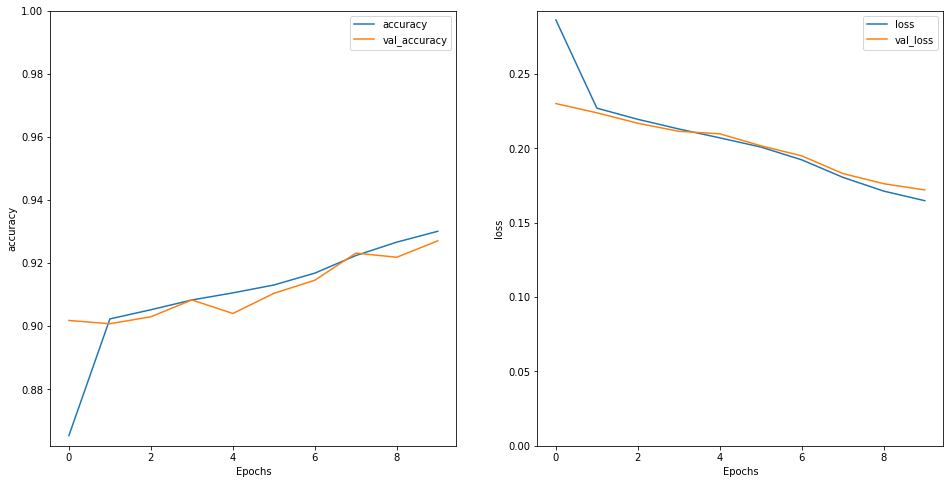

In [15]:
plt.figure(figsize=(16, 8)) #Visualizing the model
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [16]:
!mkdir -p ML_models
model.save('ML_models/RNN_model')

INFO:tensorflow:Assets written to: ML_models/RNN_model/assets


INFO:tensorflow:Assets written to: ML_models/RNN_model/assets
